In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby, xcorr
from src.statsmodels import *
import scipy

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

In [4]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype, save_fig, get_stars
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar, get_individual_perc_error
from src.pymc_modelling import get_samp

import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS

In [5]:
df = load_pd_df("df_analysis.feather")
hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

# Cross Section Expectation and perception

In [6]:
# lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i])
lst_error_cols = sorted([i for i in df.columns if "_error" in i and "mse" not in i and 'all' not in i ]) #and 'MY' not in i])
lst_error_cols
lst_error_cols = ['delta_pe_MY_error_act', 'pi_exp_MY_error_act', 'pi_perc_MY_error_act']

In [7]:
for col in lst_error_cols:
    print(col, df[['id', col]].drop_duplicates().dropna().shape)
    # plt.hist(df[['id',col]].drop_duplicates().dropna().iloc[:, 1])

delta_pe_MY_error_act (9130, 2)
pi_exp_MY_error_act (9319, 2)
pi_perc_MY_error_act (9130, 2)


In [8]:
dict_cols_pretty_names = {
    'delta_pe_MY_error_act': "$\~{\pi}^{\Delta e}_{t|t+12}$", 
    "pi_exp_MY_error_act": "$\~{\pi}^e_{t|t+12}$", 
    "pi_perc_MY_error_act": "$\~{\pi}^p_{t}$"
}

In [42]:
_ = df.set_index('id')[lst_error_cols].drop_duplicates()
ols_data = hhp[
    [
        'is_food_shop',  
        # 'pinc_midpoint', 
        'hhinc_midpoint',
        # 'hhinc',
        # 'debt_midpoint',
        # 'eduschool_txt',
        'eduwork_txt',
        # 'wealth_bank_midpoint', 
        'savings_planned', 
        'profession_txt',
        # 'ecbtrust',
        # 'pr
        # 'hhsize',
        'riskaversion',
        'hhchildren', 
        # 'is_invest_shop', 
        # 'is_unempl', 
        # 'is_cash_pay',
        # 'is_homeown', 
        'id',
    ]].set_index('id').loc[_.index].copy()
ols_data = ols_data.join(_).reset_index().groupby('id').last()
ols_data2 = ols_data.copy()

In [43]:
DICT_PARSE_COLS.update(
    {
        'hhsize': 'categoryO', 'hhinc_midpoint': float, 'pinc_midpoint': 'categoryO', 'profession_txt': 'category',
        'riskaversion': 'categoryO', 'eduschool_txt': 'category', 'savings_planned': float,
    }
)
DICT_PARSE_COLS.update({i: float for i in lst_error_cols})
ols_data = pd_df_astype(ols_data, DICT_PARSE_COLS)

In [44]:
dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'category':
        dummies = pd.get_dummies(ols_data[col].dropna(), dtype=bool, )
        dummies = dummies.add_prefix(col)
        ols_data = ols_data.join(dummies.iloc[:, :])
        ols_data = ols_data.drop(col, axis=1)
        
ols_data['const'] = np.ones(len(ols_data))
ols_data = ols_data.drop_duplicates().astype(float)

In [45]:
# multiple ols models
lst_ols_mods, lst_dfbetas, lst_ols_data = [], [], []
_ = ""
for col in lst_error_cols + ['delta_pe_MY_error_act']:
    d = ols_data.drop([i for i in lst_error_cols if i != col], axis=1)
    
    if col == "delta_pe_MY_error_act" and _ == "":
        d = d[[i for i in d.columns if 'saving' not in i and 'edu' not in i and 'debt' not in i]]
        _ = "x"
    else:
        d = d[[i for i in d.columns if 'risk' not in i]] #and 'profession' not in i]]
    d = d.dropna()
    ols = OLS(
        d[col], 
        d.drop(col, axis=1),
        hasconst=True,
    ).fit()
    
    lst_ols_data.append((d[col], d.drop(col, axis=1)))
    # dfbeta = get_dfbetas(ols.model.exog, ols.resid.values)
    # lst_dfbetas.append((d, pd.DataFrame(dfbeta, index=d.index, columns=d.columns[:-1])))
    lst_ols_mods.append(ols)

In [50]:
out = get_statsmodels_summary(lst_ols_mods, seperator=" ", tresh_sig=.15, is_filt_sig=True)
save_pd_df(out, 'tab_cross_section_error.csv', GRAPHS_DIR)

out = get_statsmodels_summary(lst_ols_mods, seperator=" ", tresh_sig=.15, is_filt_sig=False)
save_pd_df(out, 'tab_cross_section_error_appendix.csv', GRAPHS_DIR)

In [49]:
out

,delta_pe_MY_error_act,delta_pe_MY_error_act_3,pi_exp_MY_error_act,pi_perc_MY_error_act
is_food_shop,0.339 [0.615],-0.369 [-1.336],0.017 [0.088],0.087 * [1.664]
profession_txtAuszubildende,4.4 ** [2.2],1.385 [1.189],0.667 [0.804],-0.416 * [-1.897]
"profession_txtBeamtin (inkl. Richter, Berufssoldaten)",-0.467 [-0.914],0.128 [0.374],0.12 [0.496],-0.031 [-0.485]
profession_txtSelbständige,-1.097 * [-1.757],0.22 [0.598],0.15 [0.572],-0.018 [-0.265]
profession_txtSelbständige mit Beschäftigten,-0.907 [-1.067],-0.107 [-0.247],-0.197 [-0.637],0.015 [0.185]
profession_txtSonstiges,-0.892 [-1.079],-0.148 [-0.266],-0.169 [-0.432],-0.074 [-0.704]
profession_txtUnbezahlter Familienangehöriger,-0.0 [-0.931],-1.983 [-1.294],-1.336 [-1.215],-0.097 [-0.338]
riskaversion-0.0,0.0 [0.314],NaN,NaN,NaN
profession_txtArbeiter,-0.207 [-0.368],0.099 [0.291],0.08 [0.335],-0.012 [-0.185]
riskaversion1.0,-1.693 [-1.385],NaN,NaN,NaN


## risk aversion delta_pe

In [15]:
sub2 = get_statsmodels_summary(lst_ols_mods, ['conf_upper', 'conf_lower', 'coef']).copy()
sub2 = sub2.swaplevel(axis=1)['delta_pe_MY_error_act'].loc[[i for i in sub2.index if 'risk' in i]]
sub2.index = [int(float(i.split('riskaversion')[-1])) for i in sub2.index]

sub = ols_data2.loc[~ols_data2.riskaversion.isna()].copy()
sub = sub[['delta_pe_MY_error_act', 'riskaversion']].dropna()
mean = sub.delta_pe_MY_error_act.mean()
sub = sub.groupby('riskaversion', observed=True).aggregate(['mean', 'std']).droplevel(0, axis=1)
sub.index = [int(float(i)) for i in sub.index]

sub = sub.join(sub2)

In [16]:
sub3 = df[['id', 'riskaversion', 'savings_planned']].dropna().copy()
sub3['savings_planned'] = sub3['savings_planned'].replace({1: 0}) * -1

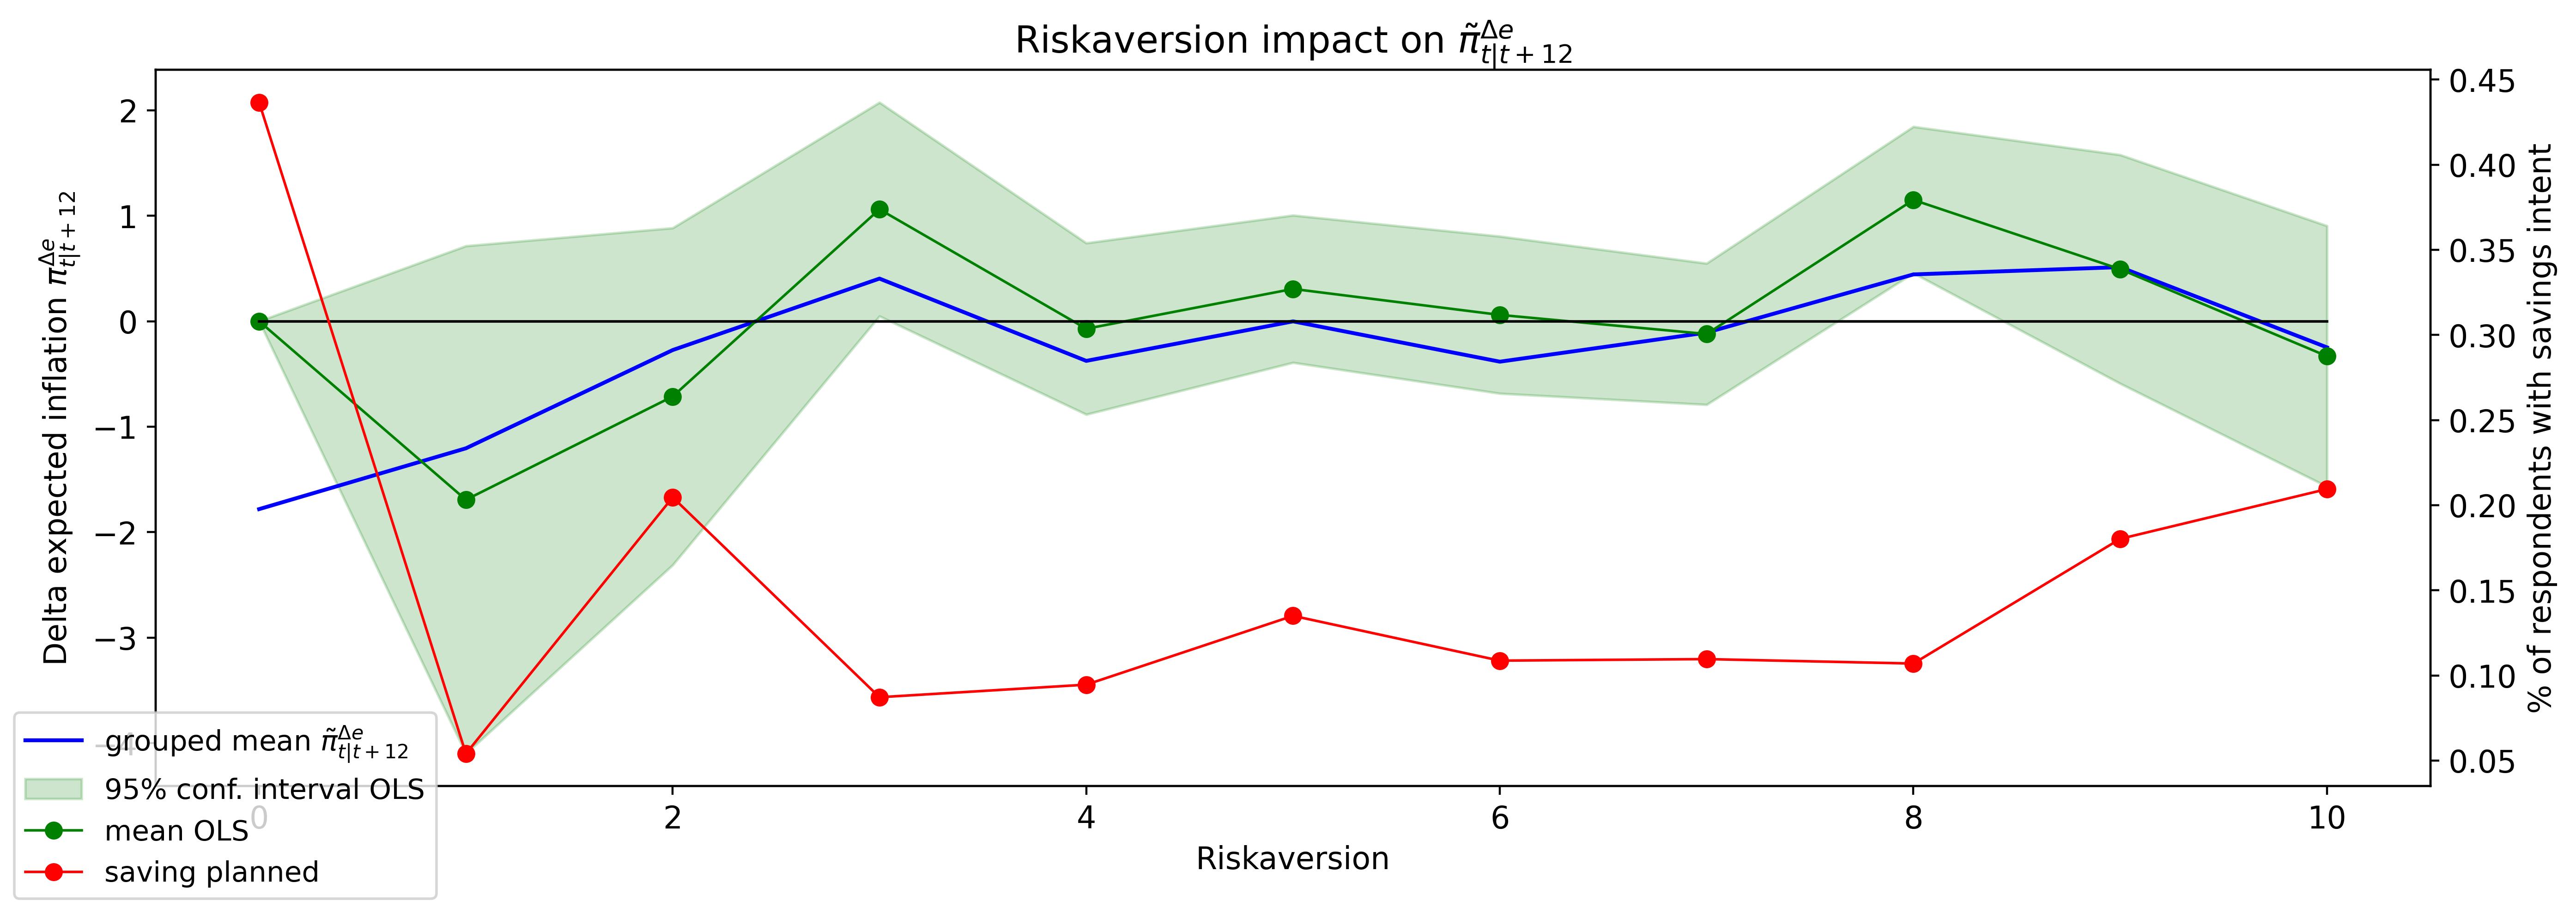

In [17]:
fig, ax = get_fig_subplots(figsize=(14,5), dpi=400)
ax.plot(sub['mean'], color='blue', label='grouped mean $\~{\pi}^{\Delta e}_{t|t+12}$')
ax.fill_between(sub.index, sub['conf_lower'], sub['conf_upper'], color='green', alpha=.2, label='95% conf. interval OLS')
ax.plot(sub['coef'], lw=1, marker='o', color='green', label='mean OLS')
ax.plot(sub.index, list([0] * len(sub2)), color='black', lw=1,)
# ax.plot(sub.index, list([mean] * len(sub)), label='global $\~{\pi}^{\Delta e}_{t|t+12}$ mean', color='blue', linestyle='dashed')

ax2 = ax.twinx()
ax2.plot(sub3.groupby('riskaversion').savings_planned.mean(), color='red', lw=1, marker='o', label='saving planned')

ax.set_xlabel("Riskaversion")
ax2.set_ylabel("% of respondents with savings intent")
ax.set_ylabel("Delta expected inflation $\pi^{\Delta e}_{t|t+12}$")
ax.set_title("Riskaversion impact on $\~{\pi}^{\Delta e}_{t|t+12}$")

fig.legend(loc='lower left', prop={'size': 11})

fig.tight_layout()
save_fig(fig, "riskaversion.png", GRAPHS_DIR)